In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.regression import *

### pycaret 설치 가이드 (Python 3.8 기준)

1. pip install pycaret==3.1.0

2. pip install joblib==1.4.2

In [2]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

FileNotFoundError: [Errno 2] No such file or directory: './big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv'

In [3]:
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

In [4]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [5]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
ID                0
HbA1c             0
Biological Sex    0
WakeTime          0
label             0
Length: 78, dtype: int64

In [6]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [7]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

### 상관관계 Matrix Heat map

In [8]:
corrdf = df.drop(columns=['datetime']).corr()

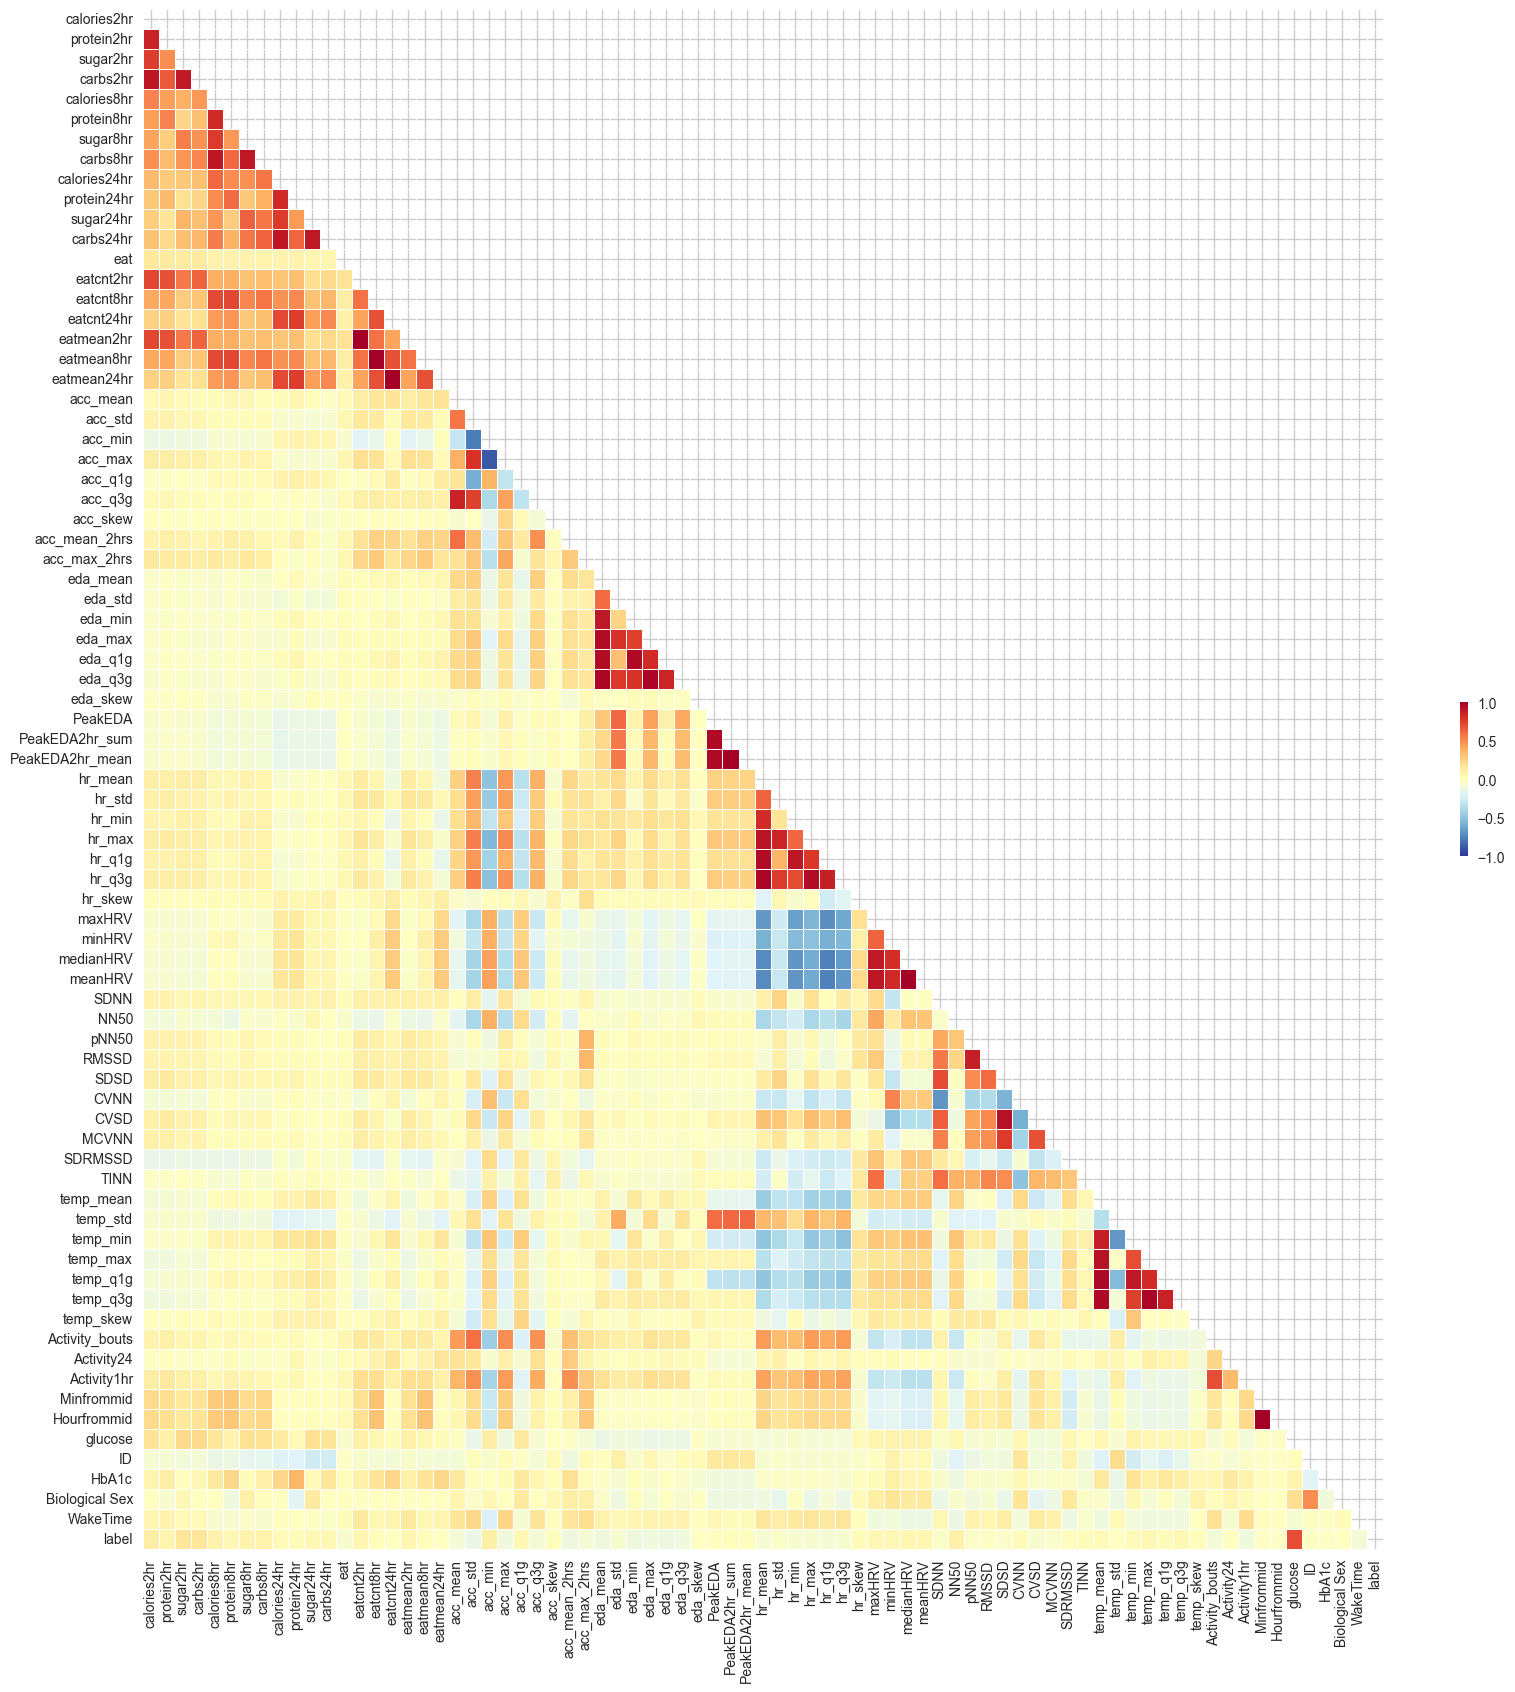

In [9]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

### Leave-one-person-out cross validation : 최적의 MSE 평균을 내는 모델을 이용한 간질 포도당 예측

def ModelCompareLOOCV(data, ids, outcomevar, dropcols, idcolumn):
    LOOCV_O = str(ids)
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    ## PYCARET
    exp = setup(data_train, test_data = data_test, target='glucose')
    comp = compare_models()

    return comp

def loocvLGBMRegressor(data, idcolumn, outcomevar, dropcols=[], numestimators=1000):
    # Make list of all ID's in idcolumn
    IDlist = list(set(data[idcolumn].astype(str))) # list(data[idcolumn]) -> list(set(data[idcolumn]))
    print(f'IDlist : {IDlist}')
    drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    
    for i in IDlist:
        comp = ModelCompareLOOCV(data, i, outcomevar, drop, idcolumn, numestimators)
        #TODO : comp로부터 각 모델 별 MAPE, MSE를 저장

        idt = str(i)
        print('...' + idt + ' processing complete.')

    #TODO : 위의 for문에서 저장한 각 모델 별 MAPE, MSE의 평균을 계산
    
    
    #TODO : RMSE의 평균이 가장 낮은 모델을 출력하기

    return 

In [10]:
import numpy as np
import pandas as pd
from pycaret.regression import setup, compare_models, predict_model

def ModelCompareLOOCV(data, ids, outcomevar, dropcols, idcolumn):
    LOOCV_O = ids #str(ids)
    data[idcolumn] = data[idcolumn] #.apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    ## PYCARET
    exp = setup(data_train, 
                test_data=data_test, 
                target=outcomevar, 
                feature_selection = True,
                feature_selection_method = 'classic', # or 'boruta' 
                n_features_to_select=15,
                pca=True,
                #feature_selection_estimator= ''
                verbose=False, 
                session_id = 123, #random state
                use_gpu = False)
    comp = compare_models(cross_validation=False, n_select=20, verbose=True)#, errors = 'raise')

    return comp, exp, data_test, y_test


def loocvModelCompareRegressor(data, idcolumn, outcomevar, dropcols=[]):
    IDlist = list(set(data[idcolumn].astype(int)))
    print(f'IDlist : {IDlist}')
    drop = [] #[idcolumn] to []
    drop = drop + dropcols
    
    model_errors = {}

    for i in IDlist:
        comp, exp, data_test, y_test = ModelCompareLOOCV(data, i, outcomevar, drop, idcolumn)
        
        for model in comp:
            model_name = model.__class__.__name__
            if model_name not in model_errors:
                model_errors[model_name] = {'MAPE': [], 'RMSE': []}
            
            # Predict on the test set
            predictions = predict_model(model, data=data_test, verbose=False)
            y_pred = predictions['prediction_label'] if 'prediction_label' in predictions.columns else predictions[outcomevar]
            
            # Calculate errors
            mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
            mse = np.mean((y_test - y_pred) ** 2)
            rmse = np.sqrt(mse)

            model_errors[model_name]['MAPE'].append(mape)
            model_errors[model_name]['RMSE'].append(rmse)

    model_avg_errors = {model: {metric: np.mean(values) for metric, values in metrics.items()} for model, metrics in model_errors.items()}
    
    print(model_avg_errors)

    # Find the top 5 models with the lowest average RMSE
    sorted_models = sorted(model_avg_errors.items(), key=lambda item: item[1]['RMSE'])
    best_models = sorted_models[:5]
    best_model_names = [model[0] for model in best_models]
    best_model_errors = {model[0]: model[1] for model in best_models}

    print(f'Best models: {best_model_names}')
    print(f'Errors: {best_model_errors}')

    # Train the best models again on the full training data
    best_models = [model for model in comp if model.__class__.__name__ in best_model_names]

    return best_models, best_model_errors, data_test

In [11]:
best_models, best_model_errors, data_test = loocvModelCompareRegressor(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'])

IDlist : [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16]
LOOCV_O : 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 25775, number of used features: 75
[LightGBM] [Info] Start training from score 117.516081


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dummy,Dummy Regressor,15.9478,347.2652,18.6351,-0.4340,0.1745,0.1603,0.4200
omp,Orthogonal Matching Pursuit,15.9644,348.5302,18.6690,-0.4392,0.1748,0.1606,0.4200
huber,Huber Regressor,15.3631,355.7632,18.8617,-0.4691,0.1736,0.1532,0.6500
gbr,Gradient Boosting Regressor,15.9199,392.3151,19.8069,-0.6200,0.1815,0.1603,10.4600
lasso,Lasso Regression,16.5463,396.8619,19.9214,-0.6388,0.1847,0.1678,0.4400
llar,Lasso Least Angle Regression,16.5463,396.8619,19.9214,-0.6388,0.1847,0.1678,0.4100
en,Elastic Net,16.5513,397.2222,19.9304,-0.6403,0.1848,0.1679,0.4400
et,Extra Trees Regressor,16.3558,399.2288,19.9807,-0.6485,0.1835,0.1640,1.1000
br,Bayesian Ridge,16.7305,407.5699,20.1884,-0.6830,0.1869,0.1697,0.4500
ridge,Ridge Regression,16.7305,408.2545,20.2053,-0.6858,0.1870,0.1697,0.4300


LOOCV_O : 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 26217, number of used features: 75
[LightGBM] [Info] Start training from score 115.768662


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,19.5029,571.6110,23.9084,-0.3487,0.1813,0.1472,2.1700
omp,Orthogonal Matching Pursuit,19.2329,611.7876,24.7343,-0.4435,0.1851,0.1389,0.4400
lasso,Lasso Regression,19.7922,612.8126,24.7551,-0.4459,0.1867,0.1468,0.4300
llar,Lasso Least Angle Regression,19.7922,612.8126,24.7551,-0.4459,0.1867,0.1468,0.4200
en,Elastic Net,19.8204,614.1270,24.7816,-0.4490,0.1869,0.1470,0.4200
dummy,Dummy Regressor,19.3811,621.3412,24.9267,-0.4660,0.1866,0.1397,0.4100
br,Bayesian Ridge,21.2325,697.3928,26.4082,-0.6454,0.2009,0.1554,0.4400
lr,Linear Regression,21.3177,703.1001,26.5160,-0.6589,0.2019,0.1559,0.5000
ridge,Ridge Regression,21.3461,704.3601,26.5398,-0.6619,0.2021,0.1561,0.4600
lar,Least Angle Regression,21.3473,704.4400,26.5413,-0.6621,0.2021,0.1561,0.4200


LOOCV_O : 4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 26173, number of used features: 75
[LightGBM] [Info] Start training from score 116.961946


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,14.0933,338.2375,18.3912,-0.0445,0.1595,0.1280,0.4400
llar,Lasso Least Angle Regression,14.0933,338.2375,18.3912,-0.0445,0.1595,0.1280,0.4200
en,Elastic Net,14.1078,338.7760,18.4059,-0.0461,0.1596,0.1280,0.4300
dummy,Dummy Regressor,13.9143,340.9340,18.4644,-0.0528,0.1623,0.1307,0.4400
omp,Orthogonal Matching Pursuit,14.0344,344.6139,18.5638,-0.0642,0.1633,0.1321,0.4200
et,Extra Trees Regressor,15.2279,436.6796,20.8969,-0.3485,0.1808,0.1454,1.0800
huber,Huber Regressor,16.8263,438.1010,20.9309,-0.3529,0.1812,0.1483,0.6400
br,Bayesian Ridge,16.5793,449.1109,21.1922,-0.3869,0.1872,0.1613,0.4200
ridge,Ridge Regression,16.7612,456.1252,21.3571,-0.4085,0.1886,0.1631,0.4200
lar,Least Angle Regression,16.7746,456.6427,21.3692,-0.4101,0.1887,0.1632,0.4400


LOOCV_O : 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 25779, number of used features: 75
[LightGBM] [Info] Start training from score 117.827107


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,12.8933,261.0838,16.1581,-0.3565,0.1563,0.1360,0.6400
gbr,Gradient Boosting Regressor,14.1748,309.3818,17.5893,-0.6074,0.1673,0.1489,9.5400
lr,Linear Regression,14.3843,317.2050,17.8103,-0.6480,0.1703,0.1518,0.4500
lar,Least Angle Regression,14.4255,318.4717,17.8458,-0.6546,0.1707,0.1522,0.4400
ridge,Ridge Regression,14.4257,318.4801,17.8460,-0.6547,0.1707,0.1522,0.4400
br,Bayesian Ridge,14.4474,319.2038,17.8663,-0.6584,0.1708,0.1524,0.4300
rf,Random Forest Regressor,14.3591,323.0017,17.9722,-0.6782,0.1687,0.1493,4.2500
et,Extra Trees Regressor,14.4613,326.8611,18.0793,-0.6982,0.1709,0.1517,1.0700
en,Elastic Net,14.7912,330.6318,18.1833,-0.7178,0.1737,0.1561,0.4300
llar,Lasso Least Angle Regression,14.7988,330.7825,18.1874,-0.7186,0.1738,0.1562,0.4400


LOOCV_O : 6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 25489, number of used features: 75
[LightGBM] [Info] Start training from score 115.921064


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,20.3585,748.3112,27.3553,0.1437,0.1983,0.1589,1.7600
llar,Lasso Least Angle Regression,19.8008,824.9914,28.7227,0.0560,0.2052,0.1448,0.4200
lasso,Lasso Regression,19.8008,824.9914,28.7227,0.0560,0.2052,0.1448,0.4300
en,Elastic Net,19.8221,830.0482,28.8106,0.0502,0.2059,0.1447,0.4200
rf,Random Forest Regressor,20.5883,856.7585,29.2704,0.0196,0.2093,0.1513,4.3700
et,Extra Trees Regressor,20.3697,867.2442,29.4490,0.0076,0.2093,0.1486,1.0900
br,Bayesian Ridge,20.0246,876.7332,29.6097,-0.0032,0.2116,0.1436,0.4500
lr,Linear Regression,20.0814,877.5036,29.6227,-0.0041,0.2118,0.1441,0.4500
ridge,Ridge Regression,20.0257,877.9658,29.6305,-0.0047,0.2118,0.1435,0.4200
lar,Least Angle Regression,20.0257,877.9846,29.6308,-0.0047,0.2118,0.1435,0.4300


LOOCV_O : 8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 25815, number of used features: 75
[LightGBM] [Info] Start training from score 116.934379


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,10.5014,190.9071,13.8169,0.2084,0.1188,0.0937,0.4500
lar,Least Angle Regression,10.5010,190.9002,13.8167,0.2084,0.1187,0.0937,0.4200
br,Bayesian Ridge,10.5269,191.2896,13.8307,0.2068,0.1189,0.0940,0.4300
lr,Linear Regression,10.5251,193.6906,13.9173,0.1969,0.1194,0.0937,0.4400
huber,Huber Regressor,10.4471,193.8053,13.9214,0.1964,0.1179,0.0908,0.6400
en,Elastic Net,11.0945,200.8425,14.1719,0.1672,0.1228,0.1005,0.4400
lasso,Lasso Regression,11.0966,201.0912,14.1807,0.1662,0.1229,0.1005,0.4500
llar,Lasso Least Angle Regression,11.0966,201.0912,14.1807,0.1662,0.1229,0.1005,0.4400
gbr,Gradient Boosting Regressor,11.2458,208.5031,14.4396,0.1355,0.1239,0.1009,10.4500
et,Extra Trees Regressor,11.4305,210.5852,14.5116,0.1268,0.1242,0.1016,1.1000


LOOCV_O : 9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 26030, number of used features: 75
[LightGBM] [Info] Start training from score 115.885939


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,16.7750,516.2540,22.7212,0.0437,0.1688,0.1338,2.7000
ridge,Ridge Regression,16.9686,554.5227,23.5483,-0.0271,0.1705,0.1264,0.4400
lar,Least Angle Regression,16.9679,554.4821,23.5474,-0.0271,0.1704,0.1264,0.4400
br,Bayesian Ridge,17.0096,557.0407,23.6017,-0.0318,0.1708,0.1266,0.4700
lr,Linear Regression,17.0819,559.4687,23.6531,-0.0363,0.1713,0.1271,0.4400
gbr,Gradient Boosting Regressor,16.9795,571.2921,23.9017,-0.0582,0.1729,0.1241,10.4600
en,Elastic Net,18.3416,640.6977,25.3120,-0.1868,0.1842,0.1331,0.4500
llar,Lasso Least Angle Regression,18.3972,644.3680,25.3844,-0.1936,0.1848,0.1334,0.4400
lasso,Lasso Regression,18.3972,644.3680,25.3844,-0.1936,0.1848,0.1334,0.4300
rf,Random Forest Regressor,18.5914,645.6802,25.4102,-0.1960,0.1873,0.1360,4.9100


LOOCV_O : 10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 26189, number of used features: 75
[LightGBM] [Info] Start training from score 117.055863


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,20.6839,837.5802,28.9410,0.0400,0.2273,0.1835,0.4300
ridge,Ridge Regression,20.6957,837.9746,28.9478,0.0396,0.2273,0.1836,0.4400
lar,Least Angle Regression,20.6960,837.9851,28.9480,0.0395,0.2273,0.1836,0.4300
lr,Linear Regression,20.7749,839.5954,28.9758,0.0377,0.2276,0.1845,0.4400
en,Elastic Net,21.1325,841.7190,29.0124,0.0353,0.2304,0.1905,0.4500
lasso,Lasso Regression,21.2365,844.1229,29.0538,0.0325,0.2311,0.1919,0.4300
llar,Lasso Least Angle Regression,21.2365,844.1229,29.0538,0.0325,0.2311,0.1919,0.4300
et,Extra Trees Regressor,21.2340,865.0514,29.4118,0.0085,0.2334,0.1901,1.0900
ada,AdaBoost Regressor,22.6417,883.1197,29.7173,-0.0122,0.2410,0.2100,1.3500
dummy,Dummy Regressor,22.2467,903.7214,30.0620,-0.0358,0.2414,0.2030,0.4300


LOOCV_O : 11
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 25494, number of used features: 75
[LightGBM] [Info] Start training from score 116.365302


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,18.6183,592.6763,24.3449,-0.0032,0.1916,0.1527,0.4200
et,Extra Trees Regressor,19.8570,603.0547,24.5572,-0.0208,0.1964,0.1717,1.0800
dummy,Dummy Regressor,18.6646,603.1454,24.5590,-0.0210,0.1929,0.1522,0.4200
lightgbm,Light Gradient Boosting Machine,19.2280,613.5351,24.7696,-0.0386,0.1959,0.1644,0.5400
gbr,Gradient Boosting Regressor,19.8102,621.3566,24.9270,-0.0518,0.1976,0.1709,10.1100
lasso,Lasso Regression,19.1294,631.0782,25.1213,-0.0682,0.1948,0.1614,0.4400
llar,Lasso Least Angle Regression,19.1294,631.0782,25.1213,-0.0682,0.1948,0.1614,0.4200
en,Elastic Net,19.1972,632.8027,25.1556,-0.0712,0.1952,0.1621,0.4400
huber,Huber Regressor,18.5839,651.1812,25.5183,-0.1023,0.1957,0.1496,0.6500
ada,AdaBoost Regressor,21.7158,666.7929,25.8223,-0.1287,0.2103,0.1937,1.7800


LOOCV_O : 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 26166, number of used features: 75
[LightGBM] [Info] Start training from score 116.333677


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,12.1049,333.4331,18.2602,0.1834,0.1361,0.0928,0.4500
lasso,Lasso Regression,12.1223,334.1259,18.2791,0.1817,0.1363,0.0929,0.4300
llar,Lasso Least Angle Regression,12.1223,334.1259,18.2791,0.1817,0.1363,0.0929,0.4200
br,Bayesian Ridge,12.6824,353.9684,18.8140,0.1331,0.1405,0.0968,0.4400
ridge,Ridge Regression,12.6924,354.5326,18.8290,0.1317,0.1406,0.0968,0.4500
lar,Least Angle Regression,12.6926,354.5480,18.8294,0.1317,0.1406,0.0968,0.4300
lr,Linear Regression,12.6524,358.7333,18.9403,0.1214,0.1416,0.0965,0.4300
ada,AdaBoost Regressor,14.5720,366.5359,19.1451,0.1023,0.1485,0.1188,1.6700
gbr,Gradient Boosting Regressor,13.7561,374.5629,19.3536,0.0827,0.1466,0.1061,10.3600
et,Extra Trees Regressor,14.2101,378.4759,19.4545,0.0731,0.1484,0.1117,1.0900


LOOCV_O : 13
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 26358, number of used features: 75
[LightGBM] [Info] Start training from score 115.822407


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,17.6078,664.4189,25.7763,-0.3930,0.1816,0.1219,1.8400
dummy,Dummy Regressor,18.3778,682.4517,26.1238,-0.4308,0.1848,0.1276,0.4300
lar,Least Angle Regression,19.5346,796.2088,28.2172,-0.6693,0.2034,0.1342,0.4400
ridge,Ridge Regression,19.5358,796.2631,28.2181,-0.6694,0.2034,0.1342,0.4600
br,Bayesian Ridge,19.5961,799.1193,28.2687,-0.6754,0.2039,0.1347,0.4400
lr,Linear Regression,19.6693,802.6819,28.3316,-0.6829,0.2045,0.1352,0.4400
huber,Huber Regressor,21.1640,875.6632,29.5916,-0.8359,0.2164,0.1459,0.6700
gbr,Gradient Boosting Regressor,21.5129,881.3214,29.6871,-0.8477,0.2171,0.1489,10.3800
en,Elastic Net,21.6832,903.4685,30.0578,-0.8942,0.2206,0.1496,0.4600
llar,Lasso Least Angle Regression,21.7831,908.7101,30.1448,-0.9052,0.2214,0.1503,0.4400


LOOCV_O : 14
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 26187, number of used features: 75
[LightGBM] [Info] Start training from score 116.644709


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,15.5064,409.0593,20.2252,0.0648,0.1640,0.1342,0.4200
llar,Lasso Least Angle Regression,15.5064,409.0593,20.2252,0.0648,0.1640,0.1342,0.4300
en,Elastic Net,15.5161,409.5691,20.2378,0.0637,0.1640,0.1343,0.4400
gbr,Gradient Boosting Regressor,15.4836,410.2560,20.2548,0.0621,0.1636,0.1340,10.4400
br,Bayesian Ridge,15.4281,410.4541,20.2597,0.0616,0.1635,0.1324,0.4400
ridge,Ridge Regression,15.4530,411.2638,20.2796,0.0598,0.1636,0.1327,0.4200
lar,Least Angle Regression,15.4534,411.2751,20.2799,0.0598,0.1636,0.1327,0.4300
huber,Huber Regressor,14.9422,412.8497,20.3187,0.0562,0.1622,0.1250,0.6300
lr,Linear Regression,15.4660,413.5553,20.3361,0.0546,0.1641,0.1328,0.4300
et,Extra Trees Regressor,15.8381,421.4610,20.5295,0.0365,0.1672,0.1374,1.0900


LOOCV_O : 15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 26755, number of used features: 75
[LightGBM] [Info] Start training from score 117.042945


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,11.7443,226.1969,15.0398,-0.0444,0.1349,0.1113,0.4300
dummy,Dummy Regressor,13.2433,276.7464,16.6357,-0.2778,0.1508,0.1293,0.4200
lightgbm,Light Gradient Boosting Machine,15.5466,364.3346,19.0875,-0.6822,0.1703,0.1418,0.5000
et,Extra Trees Regressor,16.0281,376.7449,19.4099,-0.7395,0.1720,0.1478,1.1500
knn,K Neighbors Regressor,15.4625,381.5290,19.5328,-0.7616,0.1756,0.1409,0.4900
ada,AdaBoost Regressor,16.4031,408.2472,20.2051,-0.8850,0.1793,0.1606,2.0500
rf,Random Forest Regressor,16.9478,432.7527,20.8027,-0.9981,0.1813,0.1578,4.6800
gbr,Gradient Boosting Regressor,17.1288,463.2659,21.5236,-1.1390,0.1855,0.1587,10.6600
lasso,Lasso Regression,17.3055,528.5439,22.9901,-1.4404,0.1946,0.1671,0.4400
llar,Lasso Least Angle Regression,17.3055,528.5439,22.9901,-1.4404,0.1946,0.1671,0.4400


LOOCV_O : 16
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 26184, number of used features: 75
[LightGBM] [Info] Start training from score 117.518408


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,14.3646,329.7689,18.1595,-0.1421,0.1673,0.1415,0.6600
en,Elastic Net,17.3703,418.8558,20.4660,-0.4506,0.1901,0.1755,0.4400
lasso,Lasso Regression,17.3799,419.3671,20.4785,-0.4524,0.1903,0.1756,0.4400
llar,Lasso Least Angle Regression,17.3799,419.3671,20.4785,-0.4524,0.1903,0.1756,0.4300
omp,Orthogonal Matching Pursuit,17.8482,429.7856,20.7313,-0.4884,0.1934,0.1817,0.4200
dummy,Dummy Regressor,18.2901,445.9308,21.1171,-0.5444,0.1968,0.1865,0.4300
br,Bayesian Ridge,18.2934,463.0805,21.5193,-0.6037,0.1994,0.1859,0.4300
ridge,Ridge Regression,18.3156,464.2436,21.5463,-0.6078,0.1996,0.1862,0.4400
lar,Least Angle Regression,18.3159,464.2626,21.5468,-0.6078,0.1996,0.1862,0.4300
lr,Linear Regression,18.3679,466.2664,21.5932,-0.6148,0.2000,0.1867,0.4400


{'DummyRegressor': {'MAPE': 14.56231833623158, 'RMSE': 22.46030692830766}, 'OrthogonalMatchingPursuit': {'MAPE': 14.645513720549754, 'RMSE': 22.56842213970982}, 'HuberRegressor': {'MAPE': 14.904317742654724, 'RMSE': 23.64013650543274}, 'GradientBoostingRegressor': {'MAPE': 15.463885626814529, 'RMSE': 23.461539521137865}, 'Lasso': {'MAPE': 14.649354009547, 'RMSE': 22.559684581779997}, 'LassoLars': {'MAPE': 14.649354009547002, 'RMSE': 22.559684581779997}, 'ElasticNet': {'MAPE': 14.653625264644166, 'RMSE': 22.591069224079213}, 'ExtraTreesRegressor': {'MAPE': 16.104803636293614, 'RMSE': 24.050771714975742}, 'BayesianRidge': {'MAPE': 15.293022230004029, 'RMSE': 23.490412025139857}, 'Ridge': {'MAPE': 15.323878433677796, 'RMSE': 23.53062044917508}, 'Lars': {'MAPE': 15.325343845316748, 'RMSE': 23.53212655725229}, 'RandomForestRegressor': {'MAPE': 16.515958831192588, 'RMSE': 24.71047996778619}, 'LinearRegression': {'MAPE': 15.311162330727468, 'RMSE': 23.495997673783325}, 'LGBMRegressor': {'MAPE

In [12]:
tuned_model = tune_model(best_models[0])  # 변경된 부분

predictions = predict_model(tuned_model, data=data_test, verbose=False)
y_pred = predictions['prediction_label'] if 'prediction_label' in predictions.columns else predictions['glucose']
y_test = data_test['glucose']

print("##### TUNED #####")
# Calculate errors
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
print(f'MAPE : {mape}')
print(f'RMSE : {rmse}')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,17.1031,420.6718,20.5103,-0.3346,0.1856,0.1684
1,17.8228,527.2086,22.9610,-0.0532,0.1850,0.1483
2,13.1511,270.4069,16.4441,-0.1922,0.1503,0.1294
3,19.9944,768.4820,27.7215,0.0977,0.2092,0.1607
4,12.7810,311.9800,17.6630,0.1074,0.1408,0.1105
5,18.1856,660.2716,25.6958,-0.0291,0.1911,0.1379
6,20.7632,762.5042,27.6135,0.0286,0.2184,0.1826
7,15.1392,461.9204,21.4923,-0.0253,0.1633,0.1192
8,18.5646,696.8416,26.3978,-0.4380,0.1967,0.1353


Fitting 10 folds for each of 10 candidates, totalling 100 fits
##### TUNED #####
MAPE : 17.35786622899714
RMSE : 20.302188508004498
